In [1]:
import itertools
import sys
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchinfo

In [4]:
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, train

sys.path.append(os.path.abspath(".."))
from utils import read_features, read_targets, print_info_features, print_info_targets, train_val_split, get_dimensions, \
    metrics_r, get_device, plot_history

## Set Working Device

In [5]:
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


## Read Features and Targets

In [6]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../data/chronology_prediction"))

In [7]:
targets = ["StartYear", "YearRange"]

In [8]:
X = read_features(path, f_type="tensors")
y = read_targets(path, targets, f_type="np")

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


In [9]:
print_info_features(X)

{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 768]), 
	},
	test: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
	},
}


In [10]:
print_info_targets(y)

{
	train: 
		<class 'numpy.ndarray'>
		shape   = (1719, 2)
	test: 
		<class 'numpy.ndarray'>
		shape   = (191, 2)
}


## Train-Validation Split

In [11]:
X, y = train_val_split(X, y)

In [12]:
print_info_features(X)

{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 768]), 
	},
	val: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 768]), 
	},
	test: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
		

In [13]:
print_info_targets(y)

{
	train: 
		<class 'numpy.ndarray'>
		shape   = (1547, 2)
	val: 
		<class 'numpy.ndarray'>
		shape   = (172, 2)
	test: 
		<class 'numpy.ndarray'>
		shape   = (191, 2)
}


## Scale Regression Targets

In [14]:
# Z-score Standardization
y_scaler = StandardScaler()
for subset in y.keys():
    if subset == "train":
        y[subset] = y_scaler.fit_transform(y[subset])
    else:
        y[subset] = y_scaler.transform(y[subset])

    # Convert to tensor
    y[subset] = torch.tensor(y[subset], dtype=torch.float32, device=device)

In [15]:
print_info_targets(y)

{
	train: 
		<class 'torch.Tensor'>
		shape   = torch.Size([1547, 2])
	val: 
		<class 'torch.Tensor'>
		shape   = torch.Size([172, 2])
	test: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191, 2])
}


In [16]:
# np.set_printoptions(suppress=True, precision=2)
# print(y_scaler.inverse_transform(y["test"].cpu().numpy()))

## Dimensions

In [17]:
X_dim, y_dim = get_dimensions(X, y)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 2


## Torch Datasets and Dataloaders

In [18]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## Initialize Model



In [19]:
hidden_size = 256

In [20]:
models = {
             ft: PotteryChronologyPredictor([X_dim[ft]], y_dim, hidden_size, device, chronology_target="years")
             for ft in feature_types
         } | {
             ft_txt + " + " + ft_img: PotteryChronologyPredictor([X_dim[ft_txt], X_dim[ft_img]], y_dim, hidden_size, device, chronology_target="years")
             for ft_txt, ft_img in feature_type_combos
         }

In [21]:
for ft, model in models.items():
    print(f"\n\nMODEL SUMMARY - FEATURE TYPE: {ft.upper()}")
    model.summary()



MODEL SUMMARY - FEATURE TYPE: TFIDF
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 2]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 256]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 256]                  77,056                    77,056
│    │    └─ReLU: 3-2                    [1, 256]                  [1, 256]                  --                        --
│    │    └─Dropout: 3-3                 [1, 256]                  [1, 256]                  --                        --
├─Sequential: 1-2                        [1, 256]                  [1, 2]                    --  

## Train Model

In [22]:
criterion = nn.MSELoss()
metrics = {m: metrics_r[m] for m in metrics_r.keys() if m in ["mae", "rmse", "r2", "medae"] }



** FEATURE SET: TFIDF **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 7 **
** Final Model: **
   train_loss: 0.5178
   val_loss: 0.7051
   target0: [mae: 37.8431, rmse: 50.4372, r2: 0.4908, medae: 27.6108]
   target1: [mae: 10.3719, rmse: 12.8437, r2: 0.1806, medae: 9.4738]


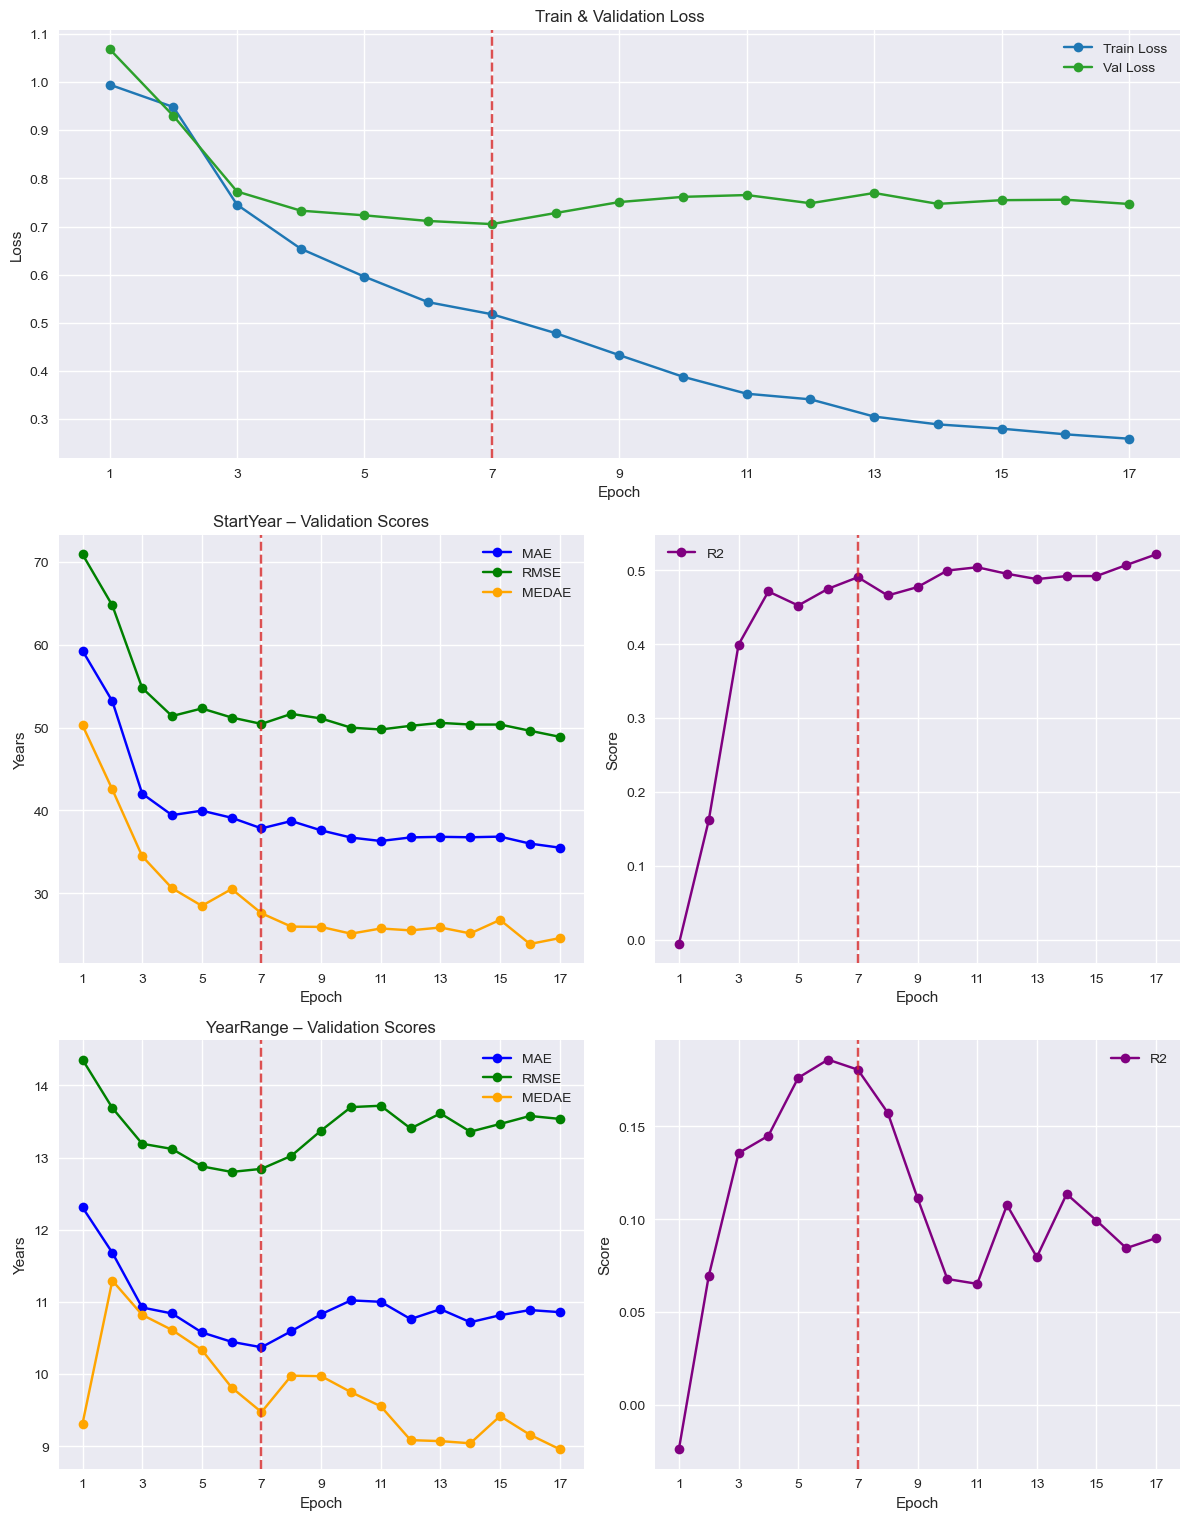



** FEATURE SET: BERT **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Final Model: **
   train_loss: 0.5917
   val_loss: 0.8287
   target0: [mae: 45.0372, rmse: 58.6867, r2: 0.3106, medae: 36.3257]
   target1: [mae: 11.2105, rmse: 13.4926, r2: 0.0957, medae: 10.8629]


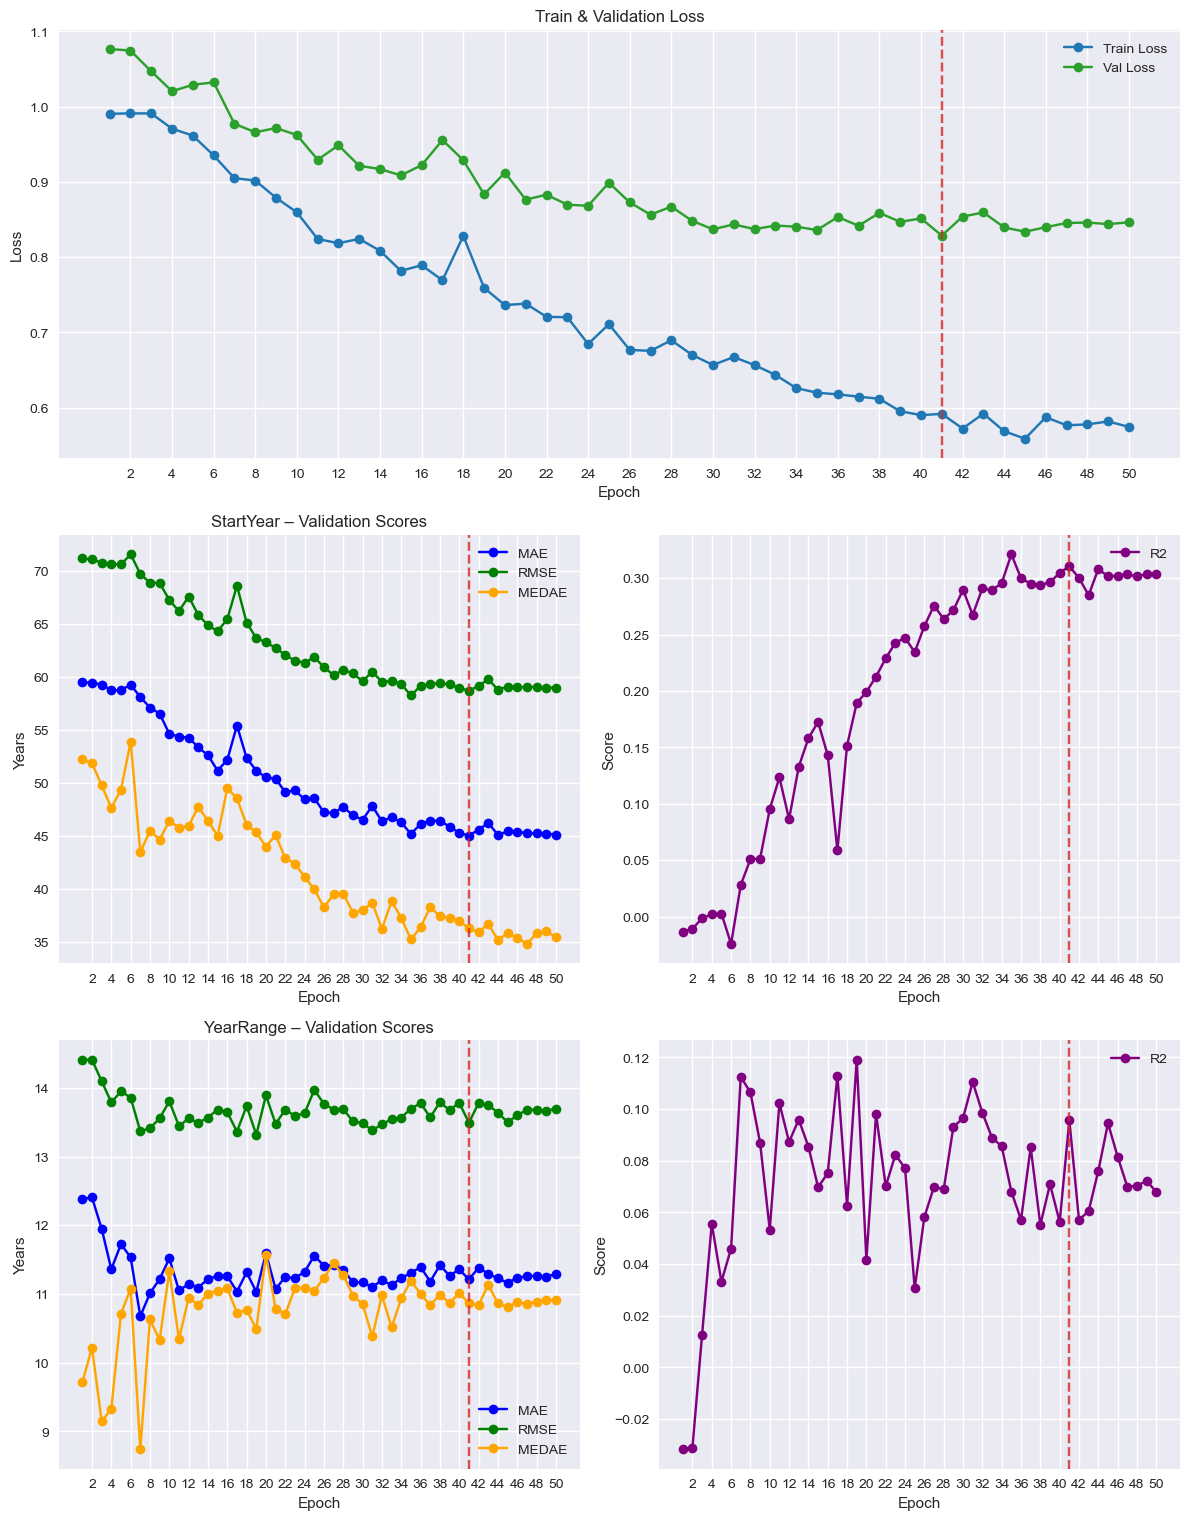



** FEATURE SET: CANNYHOG **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 2 **
** Final Model: **
   train_loss: 1.0185
   val_loss: 1.0755
   target0: [mae: 59.4863, rmse: 71.1803, r2: -0.0141, medae: 51.6048]
   target1: [mae: 12.3033, rmse: 14.3813, r2: -0.0273, medae: 9.2554]


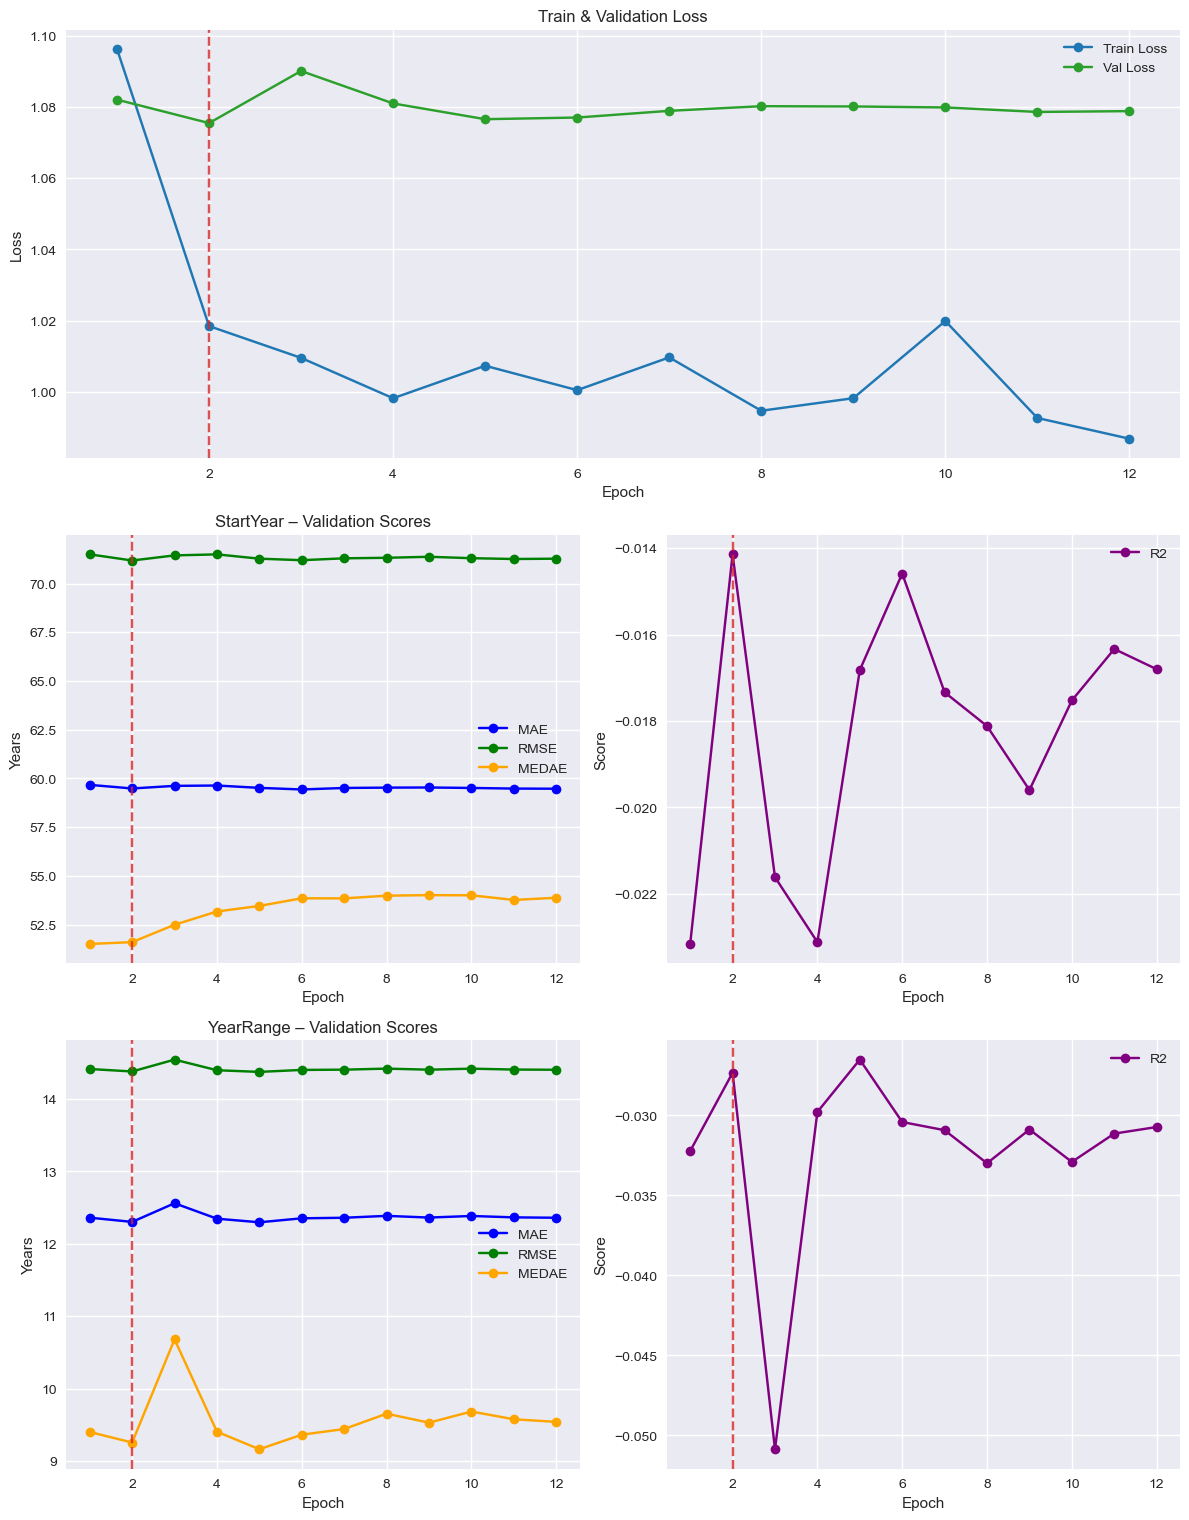



** FEATURE SET: RESNET **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 8 **
** Final Model: **
   train_loss: 0.7984
   val_loss: 0.9289
   target0: [mae: 50.5938, rmse: 62.5311, r2: 0.2173, medae: 43.0064]
   target1: [mae: 11.9371, rmse: 14.2116, r2: -0.0032, medae: 9.7932]


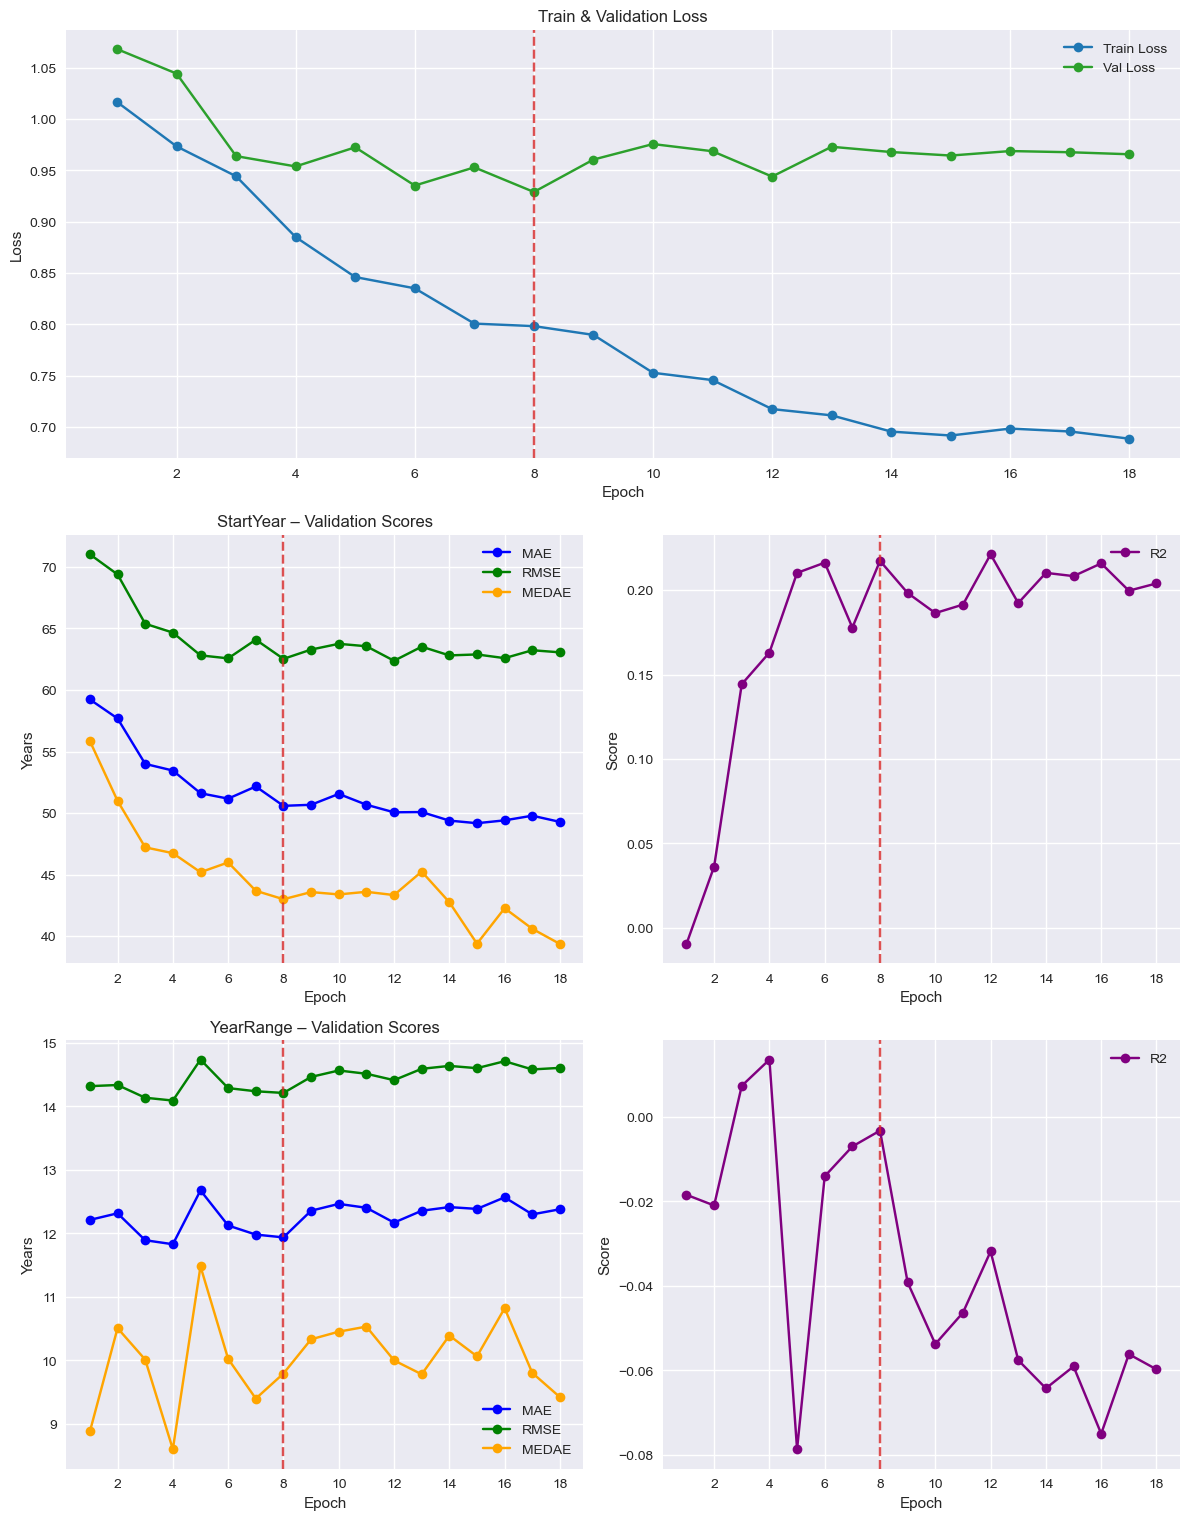



** FEATURE SET: VIT **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 11 **
** Final Model: **
   train_loss: 0.7594
   val_loss: 0.9168
   target0: [mae: 49.3525, rmse: 61.9687, r2: 0.2314, medae: 43.1045]
   target1: [mae: 11.7320, rmse: 14.0416, r2: 0.0206, medae: 8.7482]


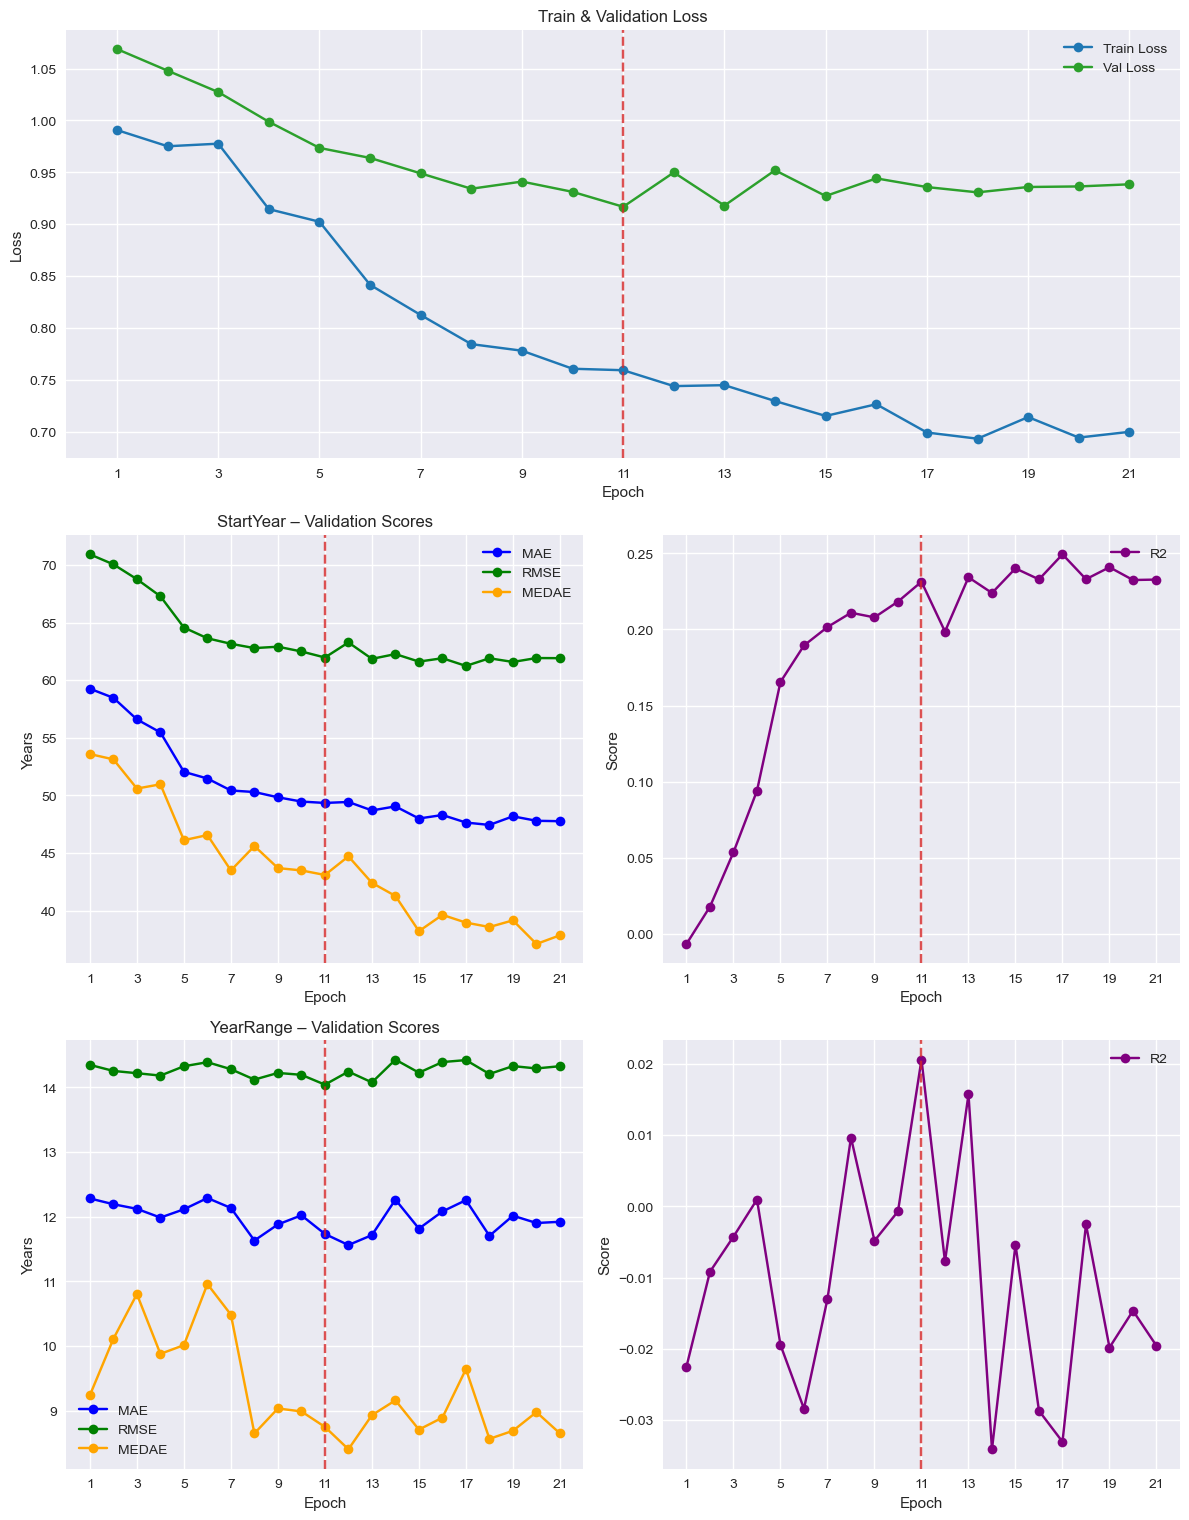



** FEATURE SET: TFIDF + CANNYHOG **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 14 **
** Final Model: **
   train_loss: 0.4931
   val_loss: 0.7218
   target0: [mae: 38.4642, rmse: 52.1578, r2: 0.4555, medae: 26.8354]
   target1: [mae: 10.5099, rmse: 12.8079, r2: 0.1852, medae: 9.9174]


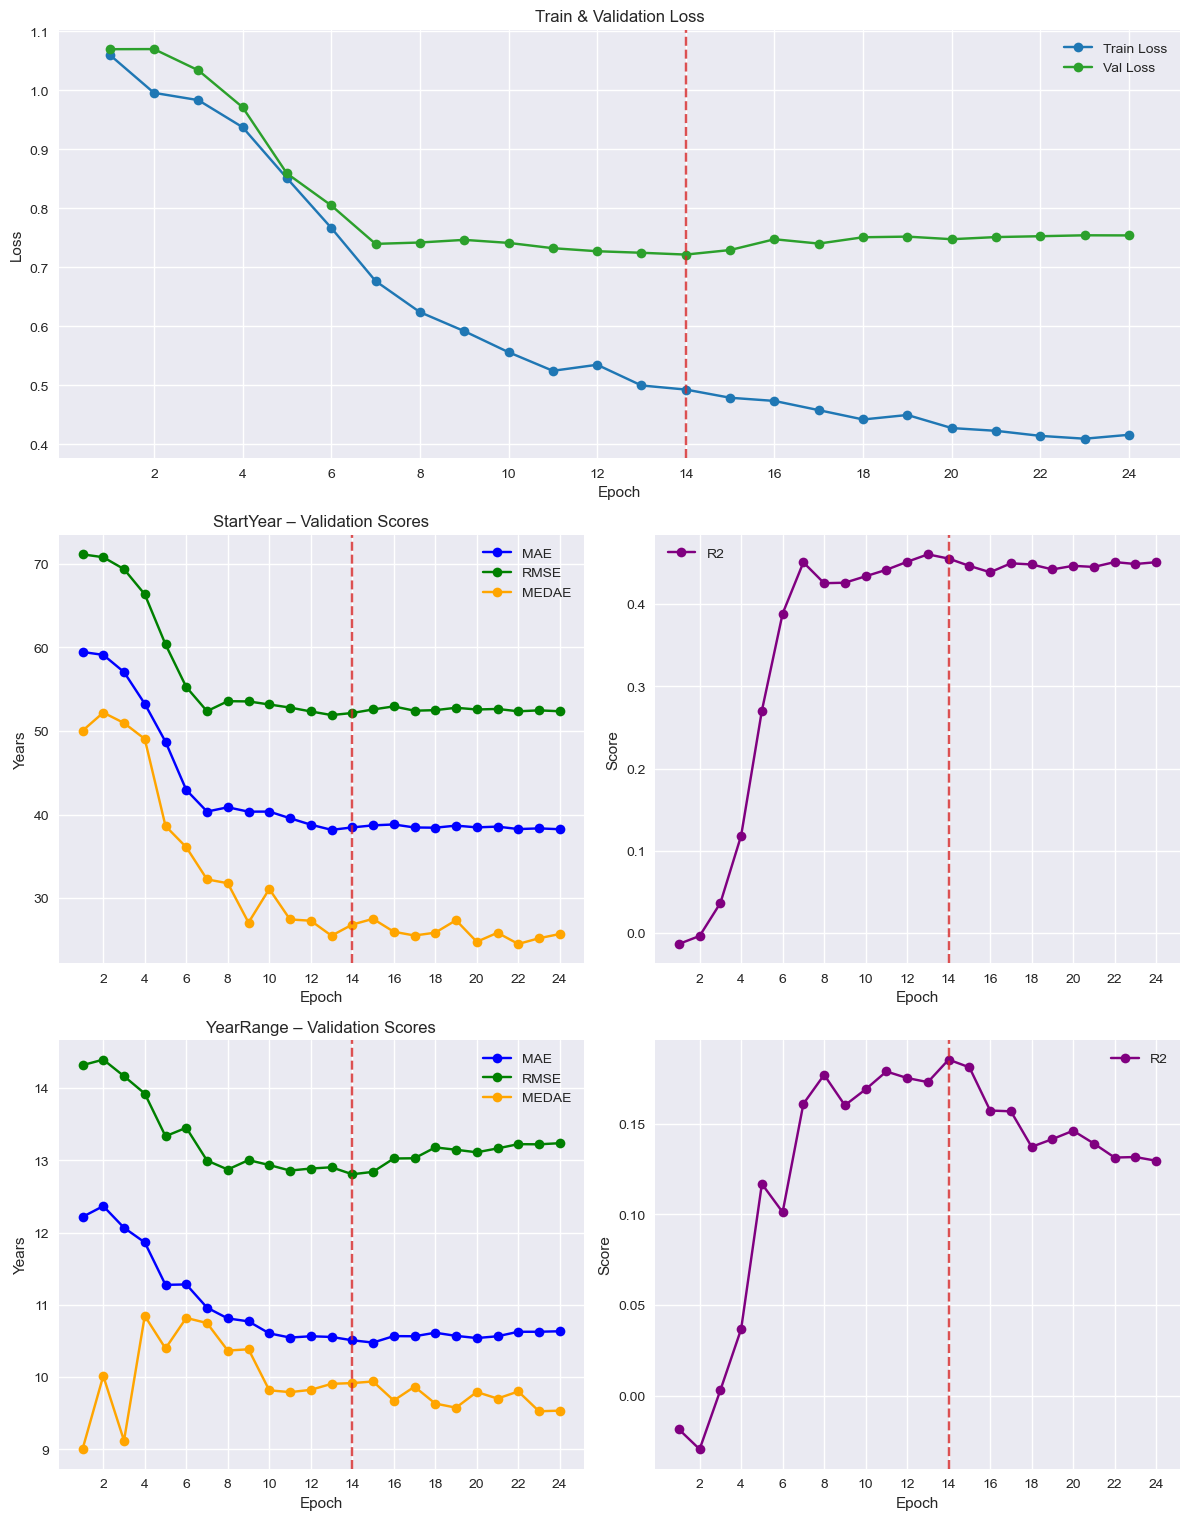



** FEATURE SET: TFIDF + RESNET **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 5 **
** Final Model: **
   train_loss: 0.5904
   val_loss: 0.6649
   target0: [mae: 36.6031, rmse: 47.2589, r2: 0.5530, medae: 28.1563]
   target1: [mae: 10.4386, rmse: 12.7737, r2: 0.1895, medae: 9.7410]


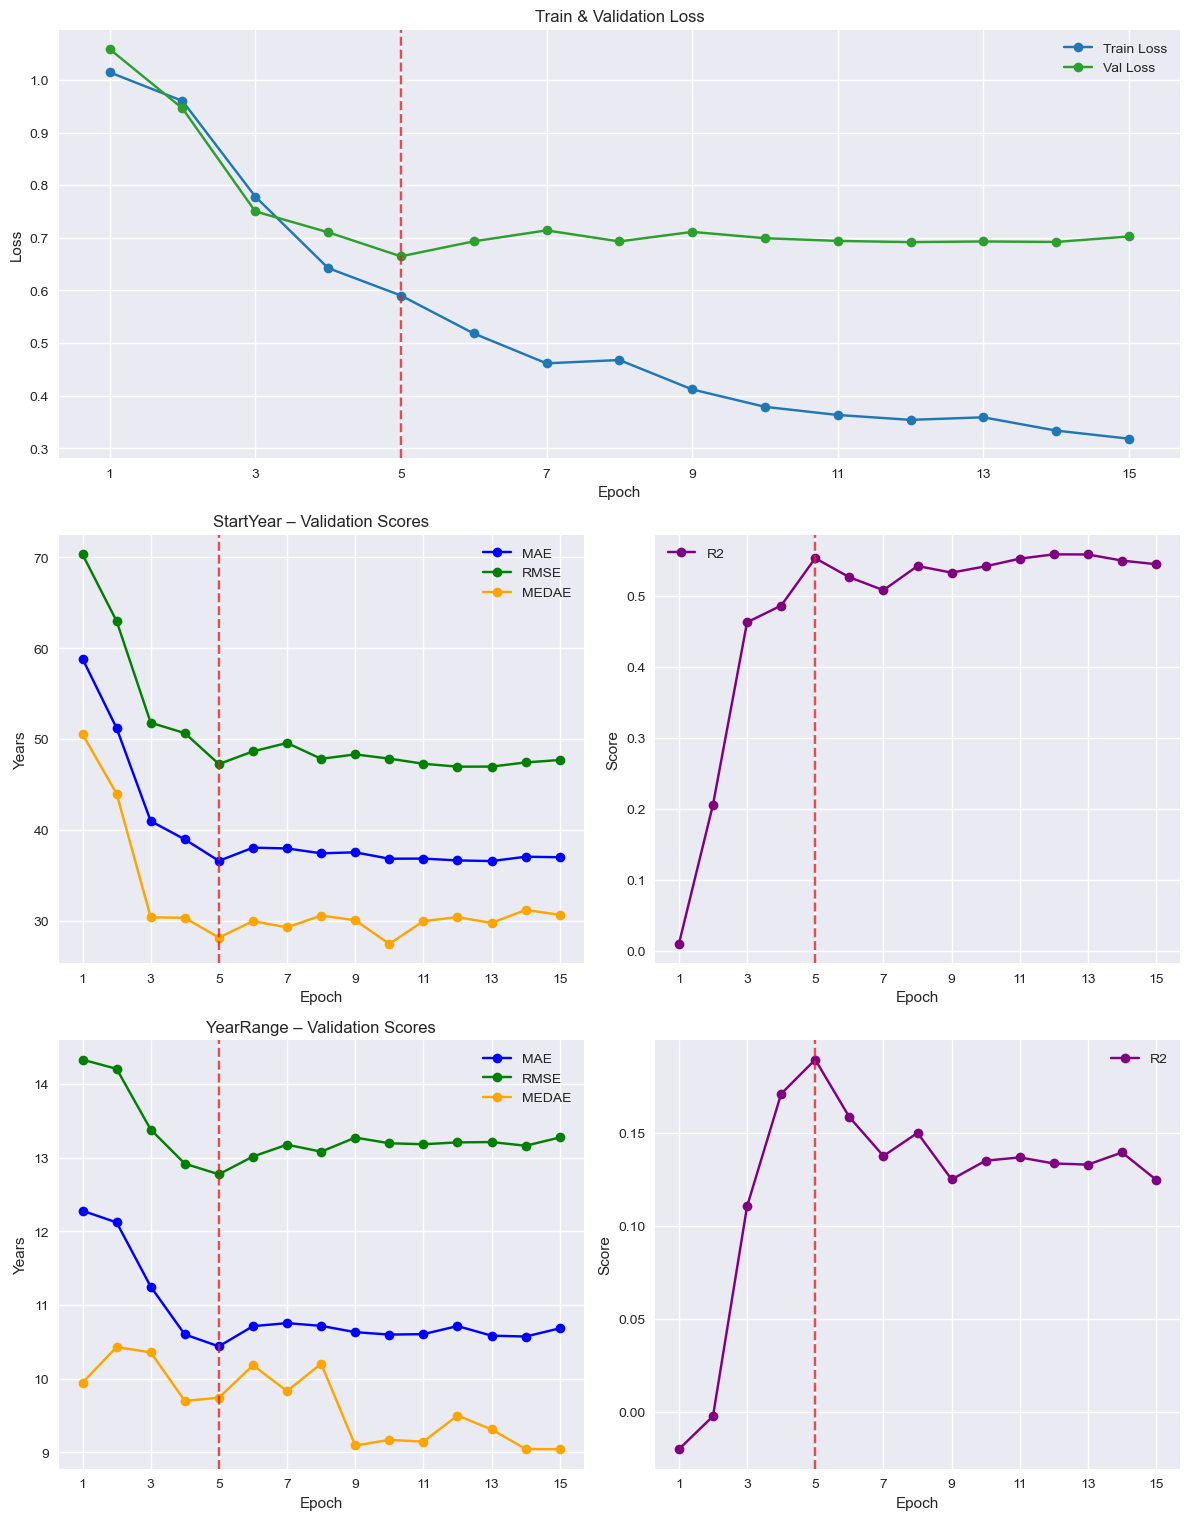



** FEATURE SET: TFIDF + VIT **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 8 **
** Final Model: **
   train_loss: 0.4766
   val_loss: 0.6542
   target0: [mae: 36.4151, rmse: 46.4528, r2: 0.5681, medae: 26.8386]
   target1: [mae: 10.2089, rmse: 12.6938, r2: 0.1996, medae: 9.1650]


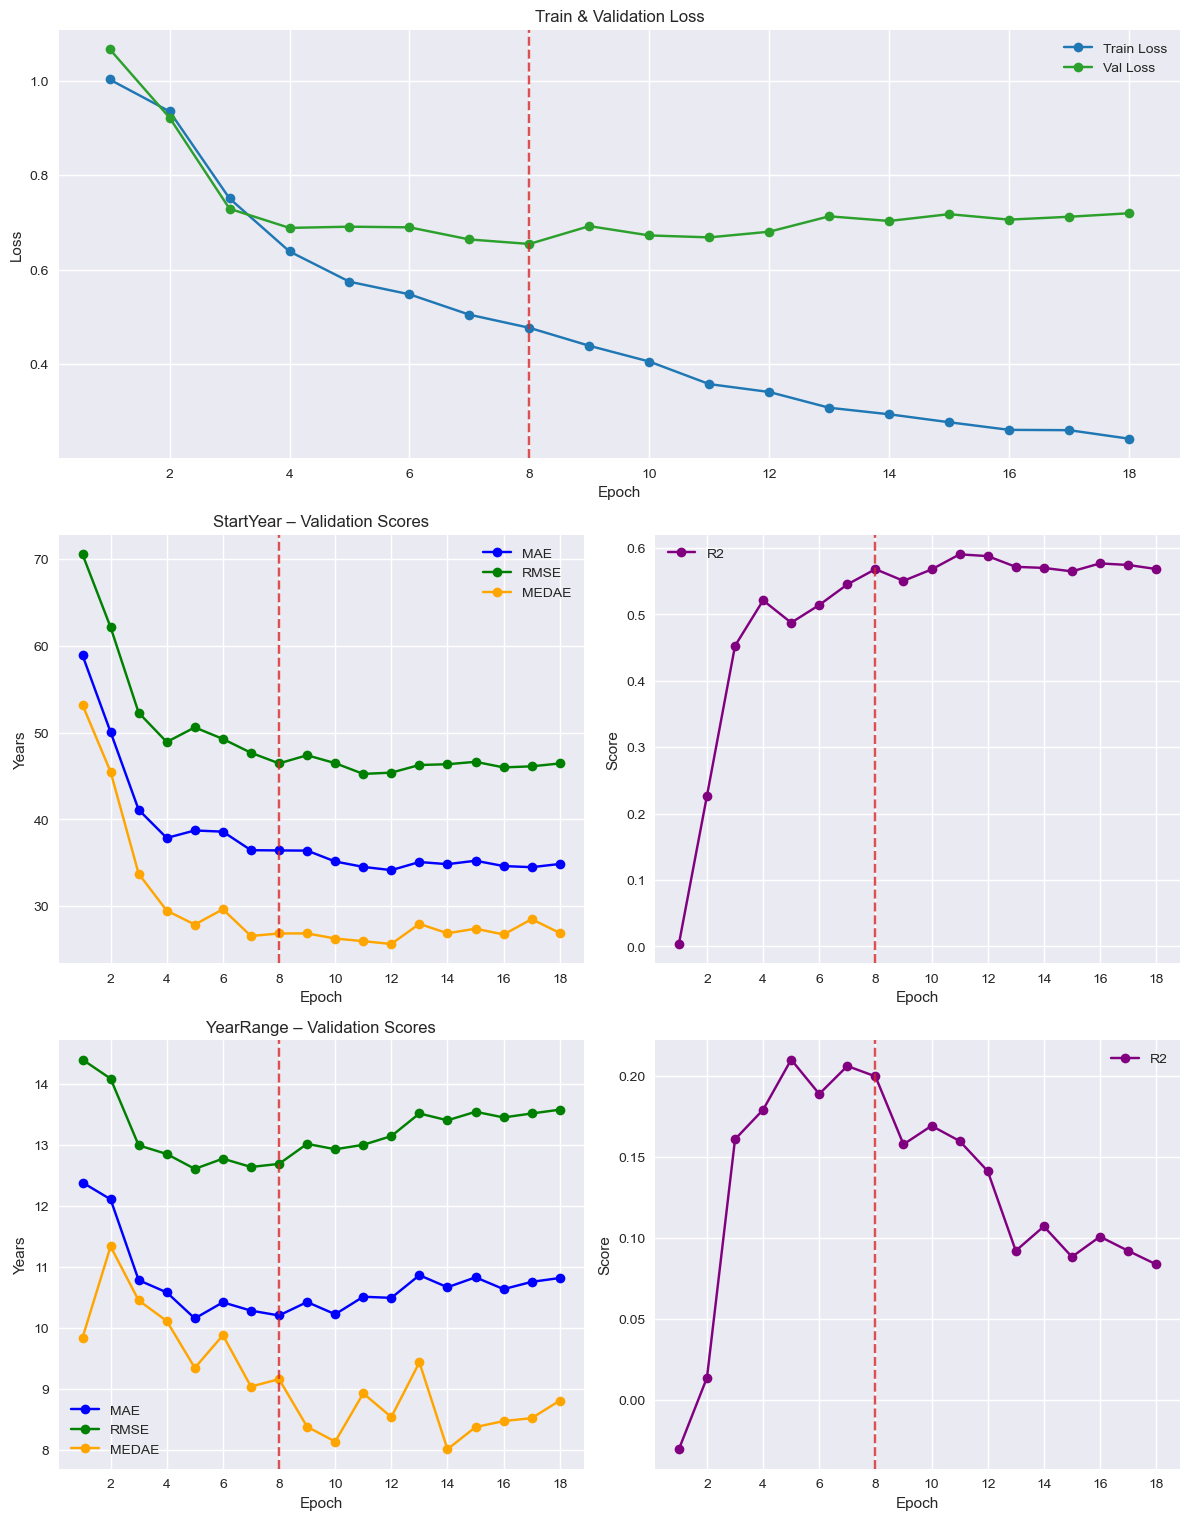



** FEATURE SET: BERT + CANNYHOG **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Final Model: **
   train_loss: 0.6082
   val_loss: 0.8160
   target0: [mae: 43.2066, rmse: 56.5561, r2: 0.3598, medae: 32.9629]
   target1: [mae: 11.3218, rmse: 13.6949, r2: 0.0684, medae: 10.8172]


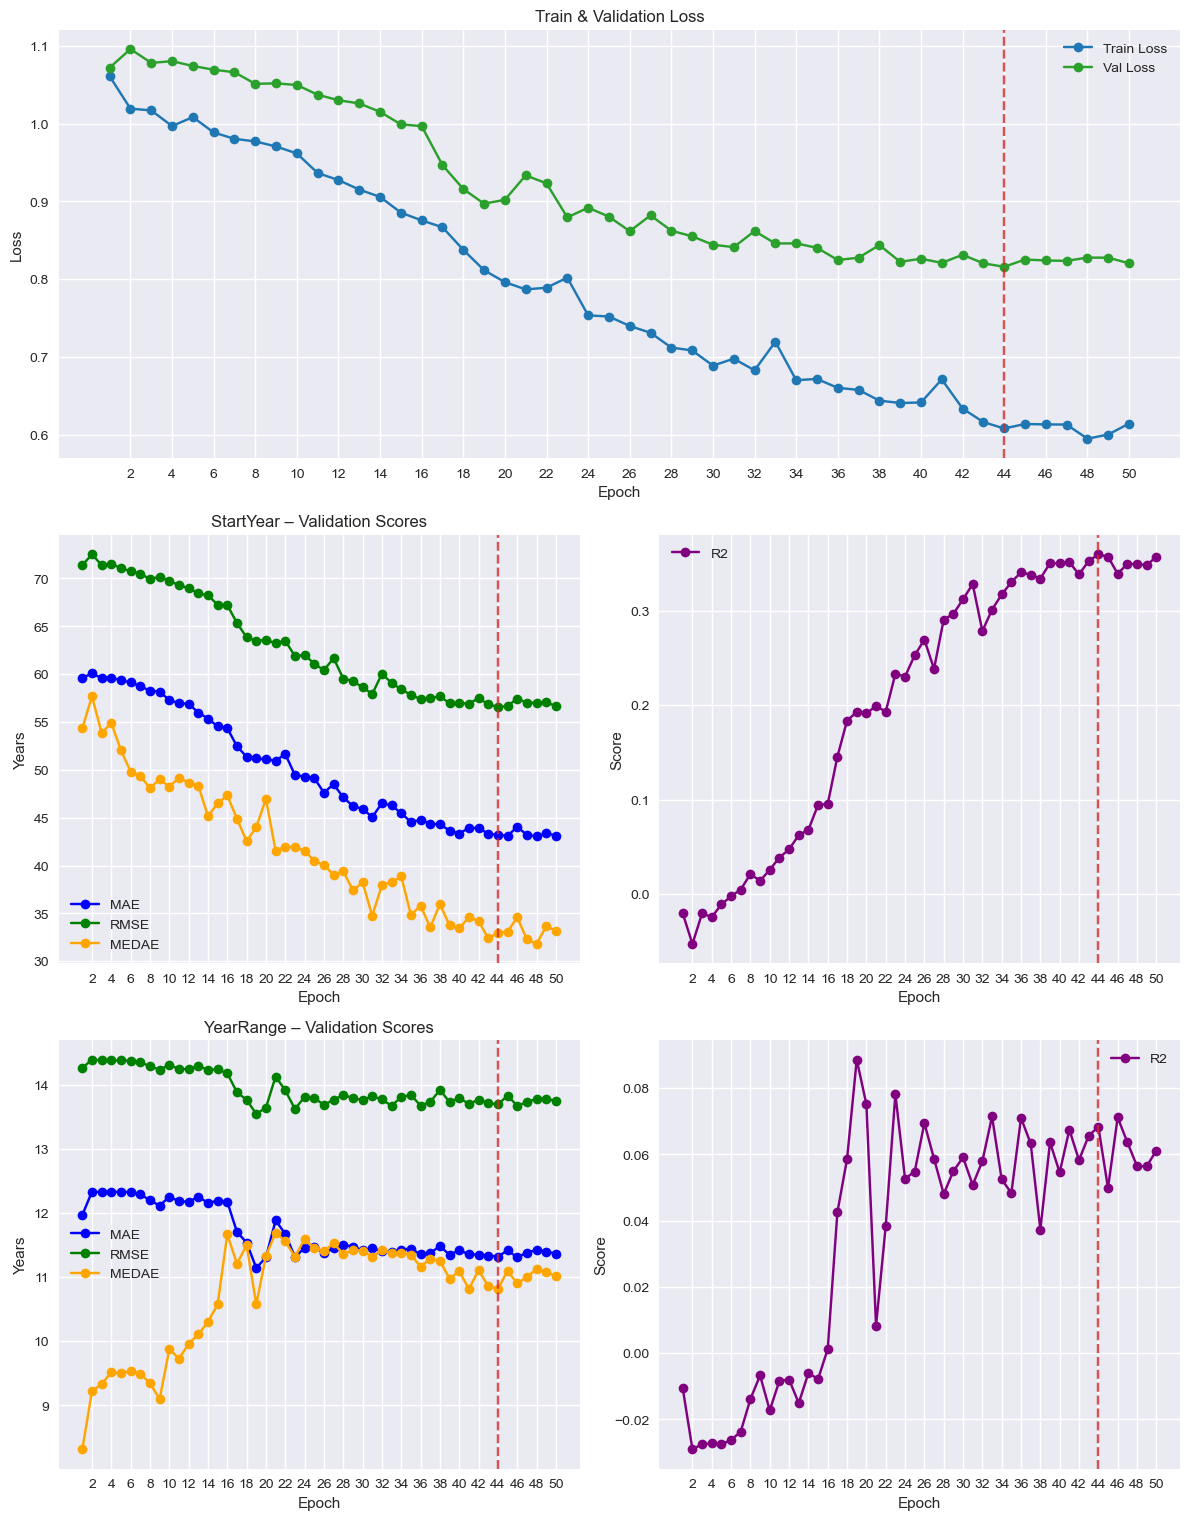



** FEATURE SET: BERT + RESNET **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 25 **
** Final Model: **
   train_loss: 0.4851
   val_loss: 0.8141
   target0: [mae: 42.5909, rmse: 56.8563, r2: 0.3529, medae: 37.2401]
   target1: [mae: 11.0777, rmse: 13.5886, r2: 0.0828, medae: 9.7894]


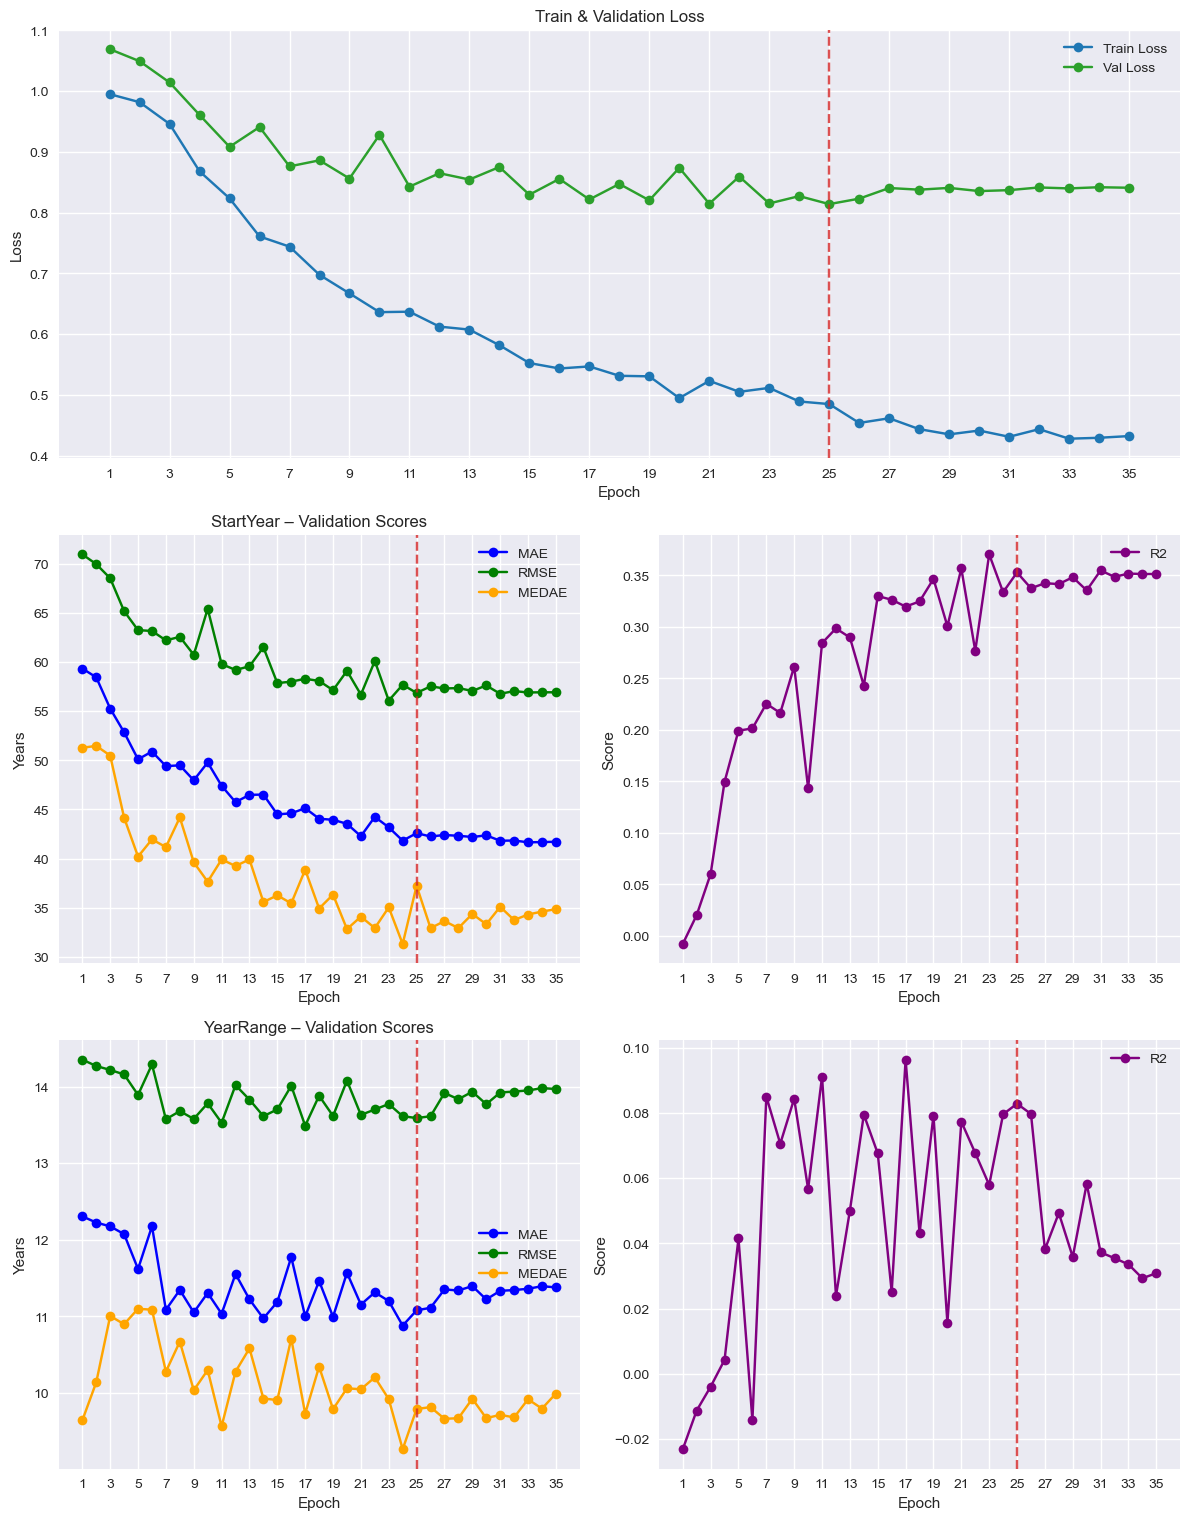



** FEATURE SET: BERT + VIT **


Epoch 01/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31/50 [ Train ]:   0%|          | 0/25 [00:00<?, ?it/s]

            [ Val  ]:   0%|          | 0/3 [00:00<?, ?it/s]

** Early Stopping **
** Restore Model State at Epoch 21 **
** Final Model: **
   train_loss: 0.5233
   val_loss: 0.7896
   target0: [mae: 41.0494, rmse: 55.5880, r2: 0.3815, medae: 32.8427]
   target1: [mae: 10.9854, rmse: 13.3935, r2: 0.1089, medae: 9.4230]


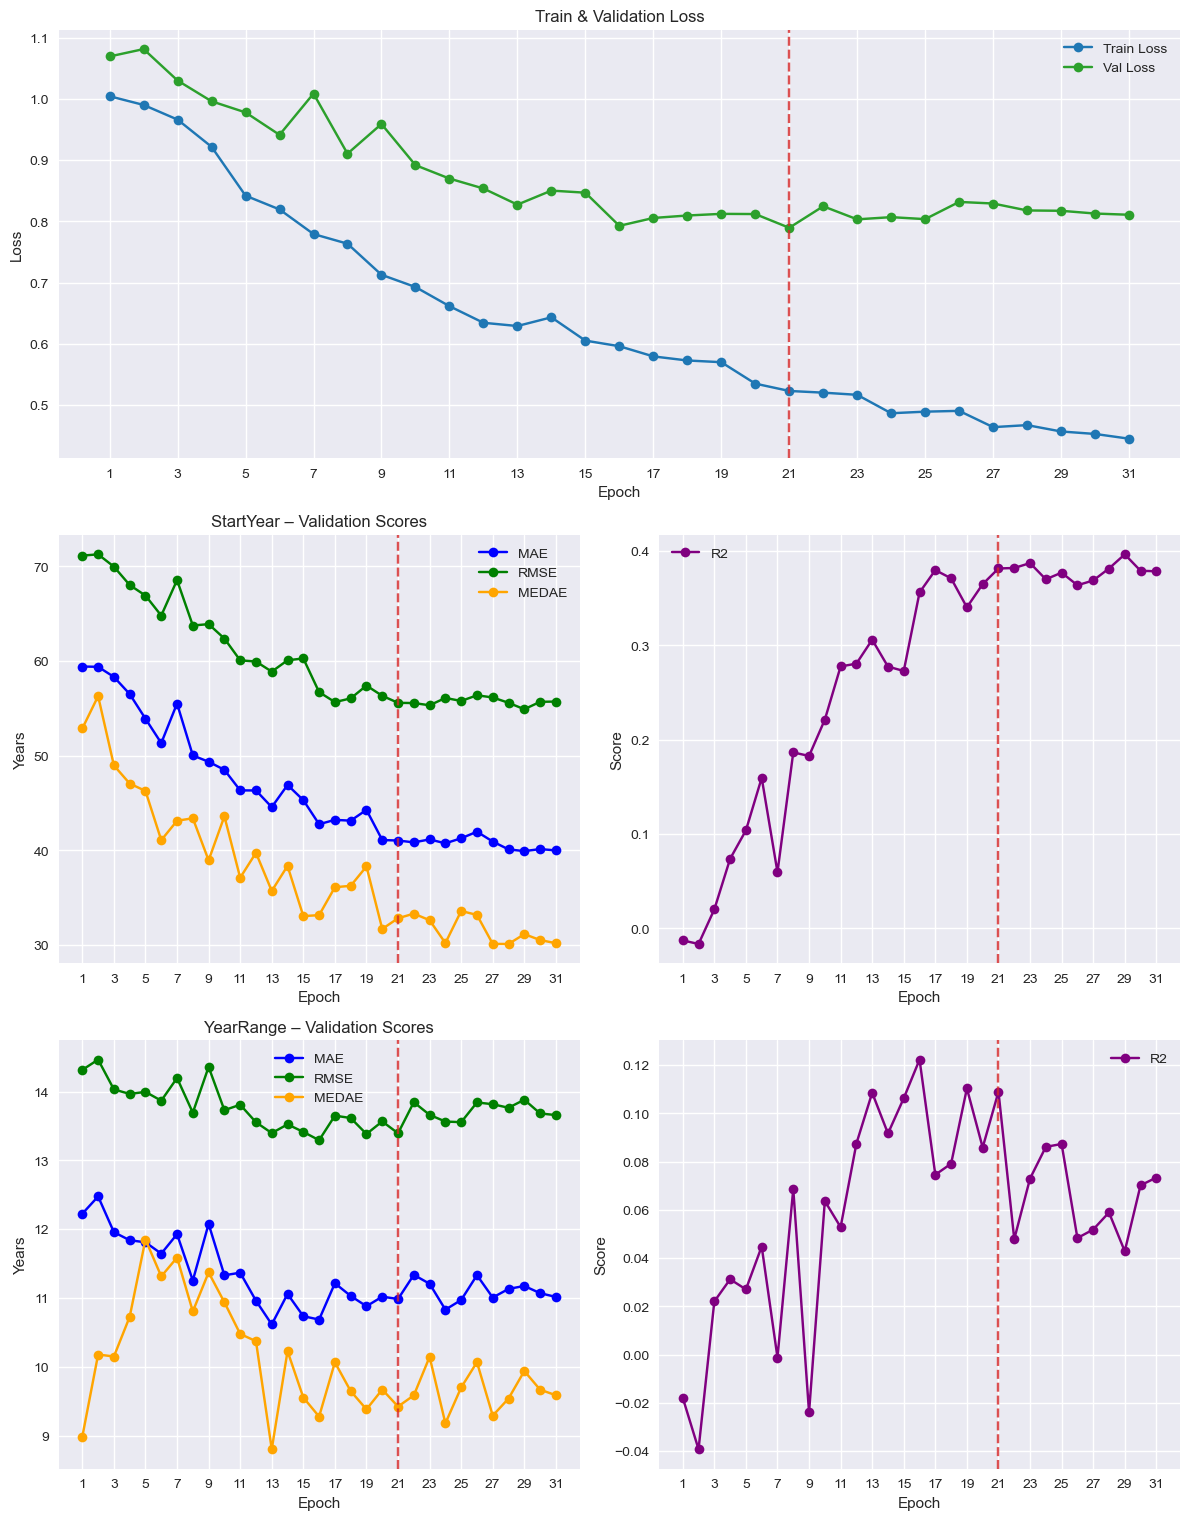

In [23]:
for ft, model in models.items():
    # if ft not in ["tfidf"]: continue
    print(f"\n\n** FEATURE SET: {ft.upper()} **")
    models[ft], history = train(model, loaders["train"][ft], loaders["val"][ft], criterion, metrics, y_scaler, lr=0.001, patience=10)
    plot_history(history, targets)